In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# importar datos
ruta = 'output_data/A_A1.csv'
data = pd.read_csv(ruta)

In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek

In [ ]:
# dividir dataset para dirigir al entrenamiento y para el test, segun el anho (2020)
train_df = data[data['year'] < 2020].copy()
test_df = data[data['year'] == 2020].copy()

In [ ]:
# presentacion de los datos para entrenar y para el test
print("Datos para el entrenamiento:")
print(train_df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nDatos para el test:")
print(test_df.head().to_markdown(index=False, numalign="left", stralign="left"))

Datos para el entrenamiento:
| datetime            | substation   | feeder   | consumption   | year   | month   | day   | hour   | day_of_week   |
|:--------------------|:-------------|:---------|:--------------|:-------|:--------|:------|:-------|:--------------|
| 2017-01-01 00:00:00 | A            | A1       | 64.6714       | 2017   | 1       | 1     | 0      | 6             |
| 2017-01-01 01:00:00 | A            | A1       | 58            | 2017   | 1       | 1     | 1      | 6             |
| 2017-01-01 02:00:00 | A            | A1       | 58            | 2017   | 1       | 1     | 2      | 6             |
| 2017-01-01 03:00:00 | A            | A1       | 58            | 2017   | 1       | 1     | 3      | 6             |
| 2017-01-01 04:00:00 | A            | A1       | 52            | 2017   | 1       | 1     | 4      | 6             |

Datos para el test:
| datetime            | substation   | feeder   | consumption   | year   | month   | day   | hour   | day_of_week   |
|:----

In [ ]:
# eliminacion de datos NAN
train_data_clean = train_df.dropna(subset=['consumption'])
test_data_clean = test_df.dropna(subset=['consumption'])

In [ ]:
# verificar que no queden datos NAN
valores_nulos_consumption = train_data_clean['consumption'].isnull().sum()
valores_nulos_consumption

0

In [ ]:
# definir funcion de lo que se quiere predecir y sus variables
def prepare_data(df):
    features = ['year', 'month', 'day', 'hour', 'day_of_week']
    X = df[features]
    y = df['consumption']
    return X, y

In [ ]:
#
X_train_clean, y_train_clean = prepare_data(train_data_clean)
X_test_clean, y_test_clean = prepare_data(test_data_clean)

In [ ]:
# modelo de regresion lineal
lr_model = LinearRegression()
# Entrenamiento del modelo
lr_model.fit(X_train_clean, y_train_clean)
# Realizar predicciones
y_pred_lr = lr_model.predict(X_test_clean)
# Metricas de desempenho
mae_lr = mean_absolute_error(y_test_clean, y_pred_lr)
mse_lr = mean_squared_error(y_test_clean, y_pred_lr)
rmse_lr = mse_lr ** 0.5

In [ ]:
print(f'Regresión Lineal - MAE: {mae_lr}, MSE: {mse_lr}, RMSE: {rmse_lr}')

Regresión Lineal - MAE: 13.728833361728672, MSE: 322.6680437521699, RMSE: 17.96296311169652


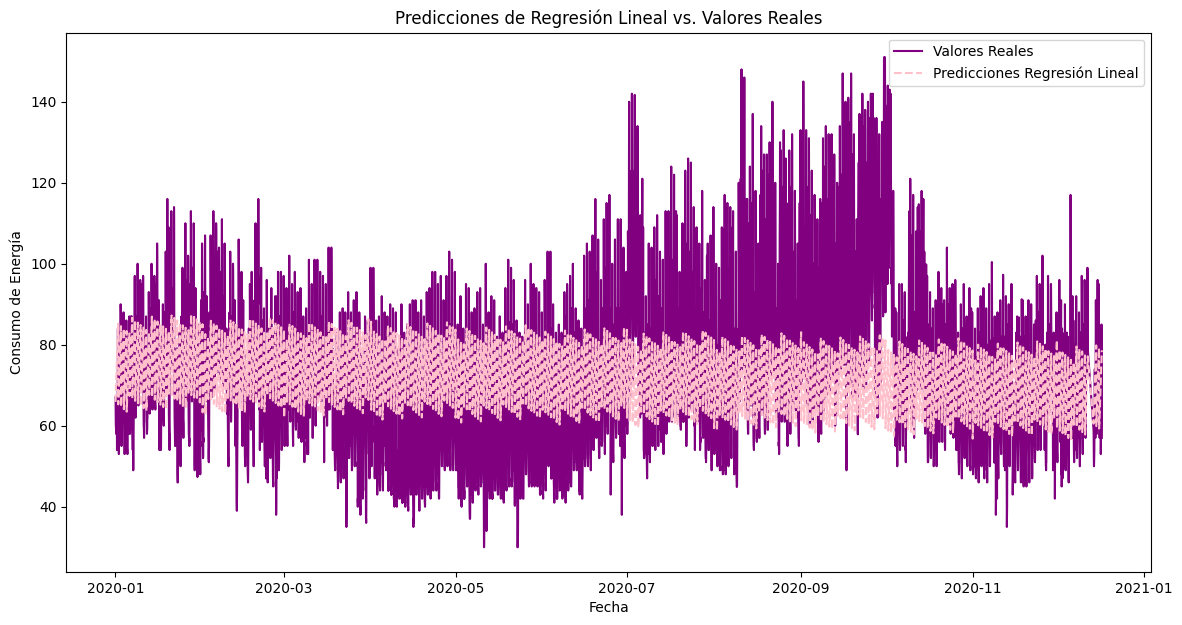

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(test_data_clean['datetime'], y_test_clean, label='Valores Reales', color='purple')
plt.plot(test_data_clean['datetime'], y_pred_lr, label='Predicciones Regresión Lineal', color='pink', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicciones de Regresión Lineal vs. Valores Reales')
plt.legend()
plt.show()

In [ ]:
# la prediccion no funciona como esperamos con la regresion lineal, procedemos a probar otro metodo

In [ ]:
# escalar datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data_clean[['consumption']])
test_scaled = scaler.transform(test_data_clean[['consumption']])

In [ ]:
# preparacion de datos para LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape de entrada para [samples, time steps, features]
time_step = 24
X_train_lstm, y_train_lstm = create_dataset(train_scaled, time_step)
X_test_lstm, y_test_lstm = create_dataset(test_scaled, time_step)

In [ ]:
# crear el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# entrenar el modelo
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=40, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

Epoch 1/10
405/405 [==============================] - 30s 50ms/step - loss: 0.0120 - val_loss: 0.0078
Epoch 2/10
405/405 [==============================] - 17s 41ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 3/10
405/405 [==============================] - 16s 41ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 4/10
405/405 [==============================] - 16s 40ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/10
405/405 [==============================] - 16s 40ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/10
405/405 [==============================] - 17s 42ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/10
405/405 [==============================] - 16s 40ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/10
405/405 [==============================] - 16s 40ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/10
405/405 [==============================] - 20s 50ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/10
405/405 [==============================] - 17s 42ms/step - loss: 0.002

In [ ]:
# realizar predicciones
train_predict = model_lstm.predict(X_train_lstm)
test_predict = model_lstm.predict(X_test_lstm)

261/261 [==============================] - 2s 9ms/step


In [ ]:
# inversa del scaler
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# calcular metricas de desempeño
y_train_lstm_aligned = y_train_clean[time_step:time_step + len(train_predict)]
y_test_lstm_aligned = y_test_clean[time_step:time_step + len(test_predict)]

In [ ]:
# graficar los resultados de entrenamiento y prueba
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

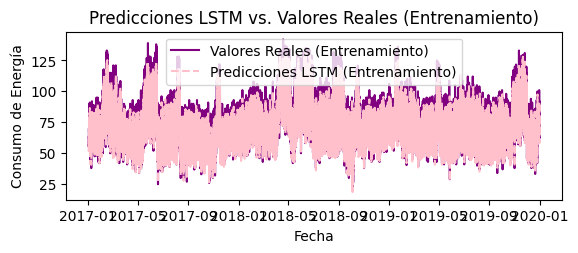

In [ ]:
# graficar datos de entrenamiento
plt.subplot(2, 1, 1)
plt.plot(train_data_clean['datetime'][time_step:time_step + len(train_predict)], y_train_lstm_aligned, label='Valores Reales (Entrenamiento)', color='purple')
plt.plot(train_data_clean['datetime'][time_step:time_step + len(train_predict)], train_predict, label='Predicciones LSTM (Entrenamiento)', color='pink', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicciones LSTM vs. Valores Reales (Entrenamiento)')
plt.legend()

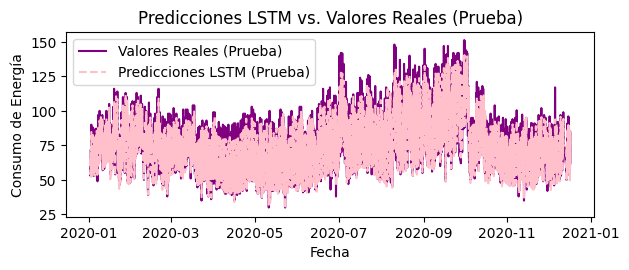

In [ ]:
# graficar datos de prueba
plt.subplot(2, 1, 2)
plt.plot(test_data_clean['datetime'][time_step:time_step + len(test_predict)], y_test_lstm_aligned, label='Valores Reales (Prueba)', color='purple')
plt.plot(test_data_clean['datetime'][time_step:time_step + len(test_predict)], test_predict, label='Predicciones LSTM (Prueba)', color='pink', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicciones LSTM vs. Valores Reales (Prueba)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# calcular metricas de rendimiento
train_rmse_lstm = np.sqrt(mean_squared_error(y_train_lstm_aligned, train_predict))
test_rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_aligned, test_predict))

print(f'LSTM - RMSE Entrenamiento: {train_rmse_lstm}')
print(f'LSTM - RMSE Prueba: {test_rmse_lstm}')

LSTM - RMSE Entrenamiento: 6.043153039877401
LSTM - RMSE Prueba: 6.144438476872102
